In [1]:
#import cftime

import pandas as pd
import geopandas as gpd
import folium
from folium.plugins import Fullscreen
import panel as pn
import holoviews as hv
import hvplot.pandas 

import matplotlib as plt
%matplotlib inline
pn.extension('tabulator')
from panel.interact import interact
import param
pn.extension(sizing_mode="stretch_width", server=True)


In [2]:
stats = pd.read_csv("data/stats_merged.csv",encoding="utf-8") # social statistics
admin = gpd.read_file("data/Stadtteile_Hamburg.shp",crs="EPSG:25832") # boundary dataset 
noise = pd.read_csv("data/admin_noise.csv",encoding="utf-8") # social statistics

#combined_indicators = pd.read_csv("data/combined_indicators.csv",encoding="utf-8") # social statistics

In [3]:
#drop unrelevant columns
stats.drop(columns=['geometry_x','geometry_y', 'geometry','bezirk_nam_x', 'bezirk_nam_y', 'ZONE_CODE', 'COUNT', 'AREA', 'MIN','MAX', 'RANGE'], inplace=True);


In [4]:
admin_stats = pd.merge(admin, stats, left_index=True, right_index=True) # merge data


In [5]:
"""-----Function to add a status column  --- """

def add_status_column(df, perc_col): #The function will be used for all of the different indicators)
    """The function adds a text column to the dataframe. The value of the text column is assigned based
        on the values of the classified "_percentile column"

    Parameters: 
        df : dataframe used for the classification
        perc_col: Column used to assign te the text values: NEEDS to be a categorial variable, resulting from the 
        "percentile functions" Has to take the classified column:result of func percentile as input
        
    Returns:
        A dataframe with a new column called "status" containing strings with the values from "very low" to "very high"
        Assignes the names based on the values in the perc_col
        
    Apply the functin:
        Example: add_status_column(dataframe, 'columnName') # 

    """
    df['status'] = ['very low' if x == 0 else  #creates the new column "status and then adds text description to the corresponding value"
                   'low' if x == 1 else
                   'medium' if x == 2 else
                   'high' if x == 3 else
                   'very high' for x in df[perc_col]]

    return df.head()

In [6]:
add_status_column(admin_stats, 'combined_indicators_percentile'); #add a new column to the frame

In [7]:
#reporjct admin stats layer
admin_stats_reproj=admin_stats.to_crs(epsg=25832)

In [8]:
#subset dataframe
stats_to_plot = admin_stats[['district','geometry','qt_soc_stats','status','weighted_area_percentile', 'z_area_per_inhbt_percentile','MEDIAN_percentile','env_multiple_burden_percentile', 'combined_indicators_percentile']]

In [9]:
#rename
stats_to_plot_rename=stats_to_plot.rename(columns={"district":"District","weighted_area_percentile":"Noise Pollution","z_area_per_inhbt_percentile":"Green Area Supply ","MEDIAN_percentile":"Thermal Burden","env_multiple_burden_percentile":"Combined Environmental Burden" , "combined_indicators_percentile":"Combined Indicators", "status":"Integrated Environmental & Social Status Index","qt_soc_stats":"Social Status"})

In [10]:
#drop NaN and reproj to Hamburg CRS
stats_to_plot_rename.dropna(inplace=True);
stats_to_plot_reproj=stats_to_plot_rename.to_crs(epsg=25832)

In [11]:
#subset data to show map with green areas and rename
greens_subset = admin_stats_reproj[['district','geometry', 'bezirk_nam','green_area_total_ha','green_area_mean_ha', 'green_space_count','z_area_per_inhbt', 'z_perc_green_area','z_area_per_inhbt_percentile']]

greens_subset=greens_subset.rename(columns={'district':'District', 'bezirk_nam':'Admin1','green_area_total_ha':'Total Green Area','green_area_mean_ha':'Mean Green Area', 'green_space_count':'Count of Green Areas','z_area_per_inhbt':'Green Area per inhabitant(sqm)', 'z_perc_green_area':'%of Green Area','z_area_per_inhbt_percentile':'Percentile Ranking Green Area per inhabitant'})
greens_subset.dropna(inplace=True);


In [12]:
#subset data set for social info


social_subset = admin_stats_reproj[['district','geometry','SHAPE_Area_x', 'inhabitants', 'bezirk_nam', 'qt_soc_stats', '%unemployed', '%social_benefits',
       '%social_housing' ,'sum_socials']]

social_subset=social_subset.rename(columns={'district':'District', 'bezirk_nam':'Admin1','qt_soc_stats':'Percentile Ranking Social Status','inhabitants':'Inhabitants','sum_socials':'Sum of Social Statistics','SHAPE_Area_x':'District Area'})
social_subset.dropna(inplace=True);
social_subset['Population Density'] =social_subset['Inhabitants']/social_subset['District Area']*100

In [13]:
#subset data set for noise info
noise_subset = admin_stats_reproj[['district','geometry','bezirk_nam', 'weighted_area_percentile', 'weighted_area']]
noise_subset=noise_subset.rename(columns={'district':'District', 'bezirk_nam':'Admin1','weighted_area_percentile':'Percentile Ranking Noise Pollution','weighted_area':'Noise affected area'})
noise_subset.dropna(inplace=True);


In [14]:
# subset dataframe without geometry column to enable plotting in hvplot
stats_reduced = admin_stats[['district', 'bezirk_nam','z_area_per_inhbt','qt_soc_stats','%unemployed', '%social_benefits','%social_housing', 'weighted_area_percentile', 'z_area_per_inhbt_percentile','MEDIAN_percentile','env_multiple_burden_percentile', 'combined_indicators_percentile', 'z_perc_green_area', 'green_space_count','weighted_area']]
stats_reduced=stats_reduced.rename(columns={"district":"District","bezirk_nam":"Admin1","z_area_per_inhbt":"green area per inhabitant(sqm)","weighted_area_percentile":"Noise Pollution","z_area_per_inhbt_percentile":"Green Area Supply" ,"MEDIAN_percentile":"Thermal Burden","env_multiple_burden_percentile":"Multiple Environmental Burden", "combined_indicators_percentile":"Combined Indicators","z_perc_green_area":"%green area per district", "green_space_count":"Count of Green Areas per District","weighted_area":"noise affected housing area","qt_soc_stats":"Social Status"})

In [15]:
stats_reduced_I = stats_reduced.interactive # makes dataframe interactive

Creation of Scatterplot

In [16]:
#scatter plot
x = pn.widgets.Select(name='Social Statistics', options=['%social_housing', '%unemployed', '%social_benefits'])
y = pn.widgets.Select(name='Environmental Statistics', options=['green area per inhabitant(sqm)', '%green area per district', 'noise affected housing area'])

plot_scatter = stats_reduced_I.hvplot(x=x, y=y, kind='scatter', colorbar=False, width=400,alpha=0.5,by="Admin1")

plot_scatter_layout = pn.Column(
    pn.pane.Markdown("### Select combinations of different variables to show scatter plot", styles={'font-weight': 'bold', 'color':'grey'}),
    plot_scatter
    
)

#plot_scatter_layout.show()

Create interactive maps with  select option

In [17]:
# Create the map viewer
class MapViewer:
    def __init__(self):
        self.map_type = 'Integrated_Indicator'
        self.view = pn.pane.HTML()

    def update_view(self):
        if self.map_type == 'Integrated_Indicator':
            self.view.object = Integrated_Indicator._repr_html_()
        elif self.map_type == 'Green_Indicator':
            self.view.object = Green_Indicator._repr_html_()
        elif self.map_type == 'Social_Indicator':
            self.view.object = Social_Indicator._repr_html_()
        elif self.map_type == 'Noise_Indicator':
            self.view.object = Noise_Indicator._repr_html_()
            
            
            
    def update_map_type(self, event):
        self.map_type = event.new
        self.update_view()

"""------------------------#create folium maps - different statistics                """

#define layer names
layer_integrated = 'Classified Indicators'
layer_greens ="Green Areas"
layer_social ="Social Statistics "
layer_noise = "Noise Pollution Statistics"


#create central map object
Integrated_Indicator =folium.Map(location=[53.55, 9.99], zoom_start=20)

#pn.pane.plot.Folium(m, height=200)


#create individual maps
Integrated_Indicator =stats_to_plot_reproj.explore('Integrated Environmental & Social Status Index', # integrated map
                   cmap='RdPu', name=layer_integrated# 
                     
                  )

pn.pane.plot.Folium(Integrated_Indicator, height=200)


Green_Indicator = folium.Map(location=[53.55, 9.99], zoom_start=14)
Green_Indicator = greens_subset.explore('Percentile Ranking Green Area per inhabitant', # green stats map
                   cmap='YlGn', name=layer_greens# color
                  )


Social_Indicator = folium.Map(location=[53.55, 9.99], zoom_start=14)
Social_Indicator = social_subset.explore('Percentile Ranking Social Status', # social stats map
                   cmap='Oranges', name=layer_social# color
                  )


Noise_Indicator = folium.Map(location=[53.55, 9.99], zoom_start=14)
Noise_Indicator=noise_subset.explore('Percentile Ranking Noise Pollution', cmap='Blues', name=layer_noise)




#background layers
folium.TileLayer(tiles="CartoDB positron", overlay=True).add_to(Integrated_Indicator)
folium.TileLayer("OpenStreetMap").add_to(Integrated_Indicator)

folium.LayerControl().add_to(Integrated_Indicator)


folium.TileLayer(tiles="CartoDB positron", overlay=True).add_to(Social_Indicator)
folium.TileLayer("OpenStreetMap").add_to(Social_Indicator)
folium.LayerControl().add_to(Social_Indicator)

folium.TileLayer(tiles="CartoDB positron", overlay=True).add_to(Green_Indicator)
folium.TileLayer("OpenStreetMap").add_to(Green_Indicator)
folium.LayerControl().add_to(Green_Indicator)

folium.TileLayer(tiles="CartoDB positron", overlay=True).add_to(Noise_Indicator)
folium.TileLayer("OpenStreetMap").add_to(Noise_Indicator)
folium.LayerControl().add_to(Noise_Indicator)




# Set width , height for the map layout
map_layout_width = 1000
map_layout_height = 400

# Create the map viewer
map_viewer = MapViewer()

pn.pane.plot.Folium(Green_Indicator, height=400)
pn.pane.plot.Folium(Noise_Indicator, height=400)


# Create the radio buttons
indicators_radio = pn.widgets.RadioButtonGroup(
    name='map',
    options=['Integrated_Indicator', 'Green_Indicator','Social_Indicator','Noise_Indicator'],
    button_type='default'
)

# Set up the event handler for radio button changes
indicators_radio.param.watch(map_viewer.update_map_type, 'value')

# Set up the initial view
map_viewer.update_view()

# Create a panel layout with the radio buttons and the map view
#map_layout = pn.Column(indicators_radio, map_viewer.view, pn.pane.plot.Folium(height=200))
map_layout = pn.Column(indicators_radio, map_viewer.view, sizing_mode='fixed', width=map_layout_width, height=map_layout_height)

# Show the panel layout
#map_layout.show()



Create interactive table 

In [18]:
# Get the unique district names
district_names = list(stats_reduced['District'].unique())

# Create the dropdown widget for selecting the district
district_dropdown = pn.widgets.Select(name='Select District', options=district_names)

# Define a callback function for filtering the data based on the selected district
def filter_data(event):
    selected_district = district_dropdown.value
    filtered_data = stats_reduced[stats_reduced['District'] == selected_district]
    stats_table.value = filtered_data

# Register the callback function with the dropdown widget
district_dropdown.param.watch(filter_data, 'value')

# Create the interactive table
stats_table = pn.widgets.Tabulator(stats_reduced, pagination='remote', page_size=10, sizing_mode='stretch_width')

# Create the "Reset" button
reset_button = pn.widgets.Button(name='Reset')

# Define a callback function for resetting the filter
def reset_filter(event):
    district_dropdown.value = None
    stats_table.value = stats_reduced

# Register the callback function with the "Reset" button
reset_button.on_click(reset_filter)
# Create the layout with the dropdown and table
table_layout = pn.Column(district_dropdown, reset_button, stats_table)

# Display the layout
#table_layout


Create Plot to show occurance of Percentile Ranking

In [19]:
#counts the number of occurances of each individual indicator per percentile ranking
counts_occurrence = pd.DataFrame({
    'qt_soc_stats': stats_to_plot['qt_soc_stats'].value_counts(),
    'weighted_area_percentile': stats_to_plot['weighted_area_percentile'].value_counts(),
    'z_area_per_inhbt_percentile': stats_to_plot['z_area_per_inhbt_percentile'].value_counts(),
    'MEDIAN_percentile': stats_to_plot['MEDIAN_percentile'].value_counts(),

})
counts_occurrence

qt_soc_stats  weighted_area_percentile  z_area_per_inhbt_percentile  \
0.0            19                        19                           16   
1.0            18                        18                           18   
2.0            17                        19                           18   
3.0            16                        18                           16   
4.0            14                        19                           16   

     MEDIAN_percentile  
0.0                 21  
1.0                 20  
2.0                 22  
3.0                 19  
4.0                 21

In [20]:
#create bar chart of occurencess
bar_chart = counts_occurrence.hvplot.bar(xlabel='Ranking', ylabel='Count', title='Counts of Status Class',
                                          stacked=True, legend='top_right', width=800, height=500)
bar_plot = pn.panel(bar_chart)
#bar_plot.show()


#### Prepare Layout

FastListTemplate
    [js_area] HTML(None, height=0, margin=0, sizing_mode='fixed', width=0)
    [actions] TemplateActions()
    [browser_info] BrowserInfo(dark_mode=False, device_pixel_ratio=1.2000000476837158, language='de', timezone='Europe/Berlin', timezone_offset=-120, webdriver=False)
    [busy_indicator] LoadingSpinner(height=20, width=20)
    [2172448674768] Row(sizing_mode='stretch_width')
        [0] Column(sizing_mode='stretch_width')
            [0] RadioButtonGroup(name='map', options=['Integrated_Indicator', ...], sizing_mode='stretch_width', value='Integrated_Indicator')
            [1] HTML(str, sizing_mode='stretch_width')
            [2] HSpacer()
    [2172448677408] Row(sizing_mode='stretch_width')
        [0] Column(sizing_mode='stretch_width')
            [0] Column(sizing_mode='stretch_width')
                [0] Markdown(str, sizing_mode='stretch_width', styles={'font-weight': 'bold', ...})
                [1] Interactive(Interactive, sizing_mode='stretch_width')
        [1] Column(sizing_mode='stretch_width')
            [0] HoloViews(Bars, height=500, sizing_mode='fixed', width=800)
    [2172448676256] Row(sizing_mode='stretch_width')
        [0] Column(sizing_mode='stretch_width')
            [0] Column(sizing_mode='stretch_width')
                [0] Select(options=['Hamburg-Altstadt', ...], sizing_mode='stretch_width', value='Hamburg-Altstadt')
                [1] Button(name='Reset', sizing_mode='stretch_width')
                [2] Tabulator(page_size=10, pagination='remote', sizing_mode='stretch_width', value=              ...)
    [2172449004080] Markdown(str, sizing_mode='stretch_width')
    [2172449001776] JPG(str, height=80, sizing_mode='stretch_width')
    [2172420099040] Markdown(str, sizing_mode='stretch_width')
    [2172448972320] Markdown(str, sizing_mode='stretch_width')
    [2172448969056] PNG(str, height=200, sizing_mode='stretch_width')
    [2172449002448] Markdown(str, sizing_mode='stretch_width')
    [2172443157888] Markdown(str, sizing_mode='stretch_width')
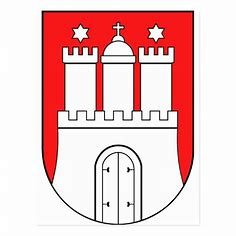
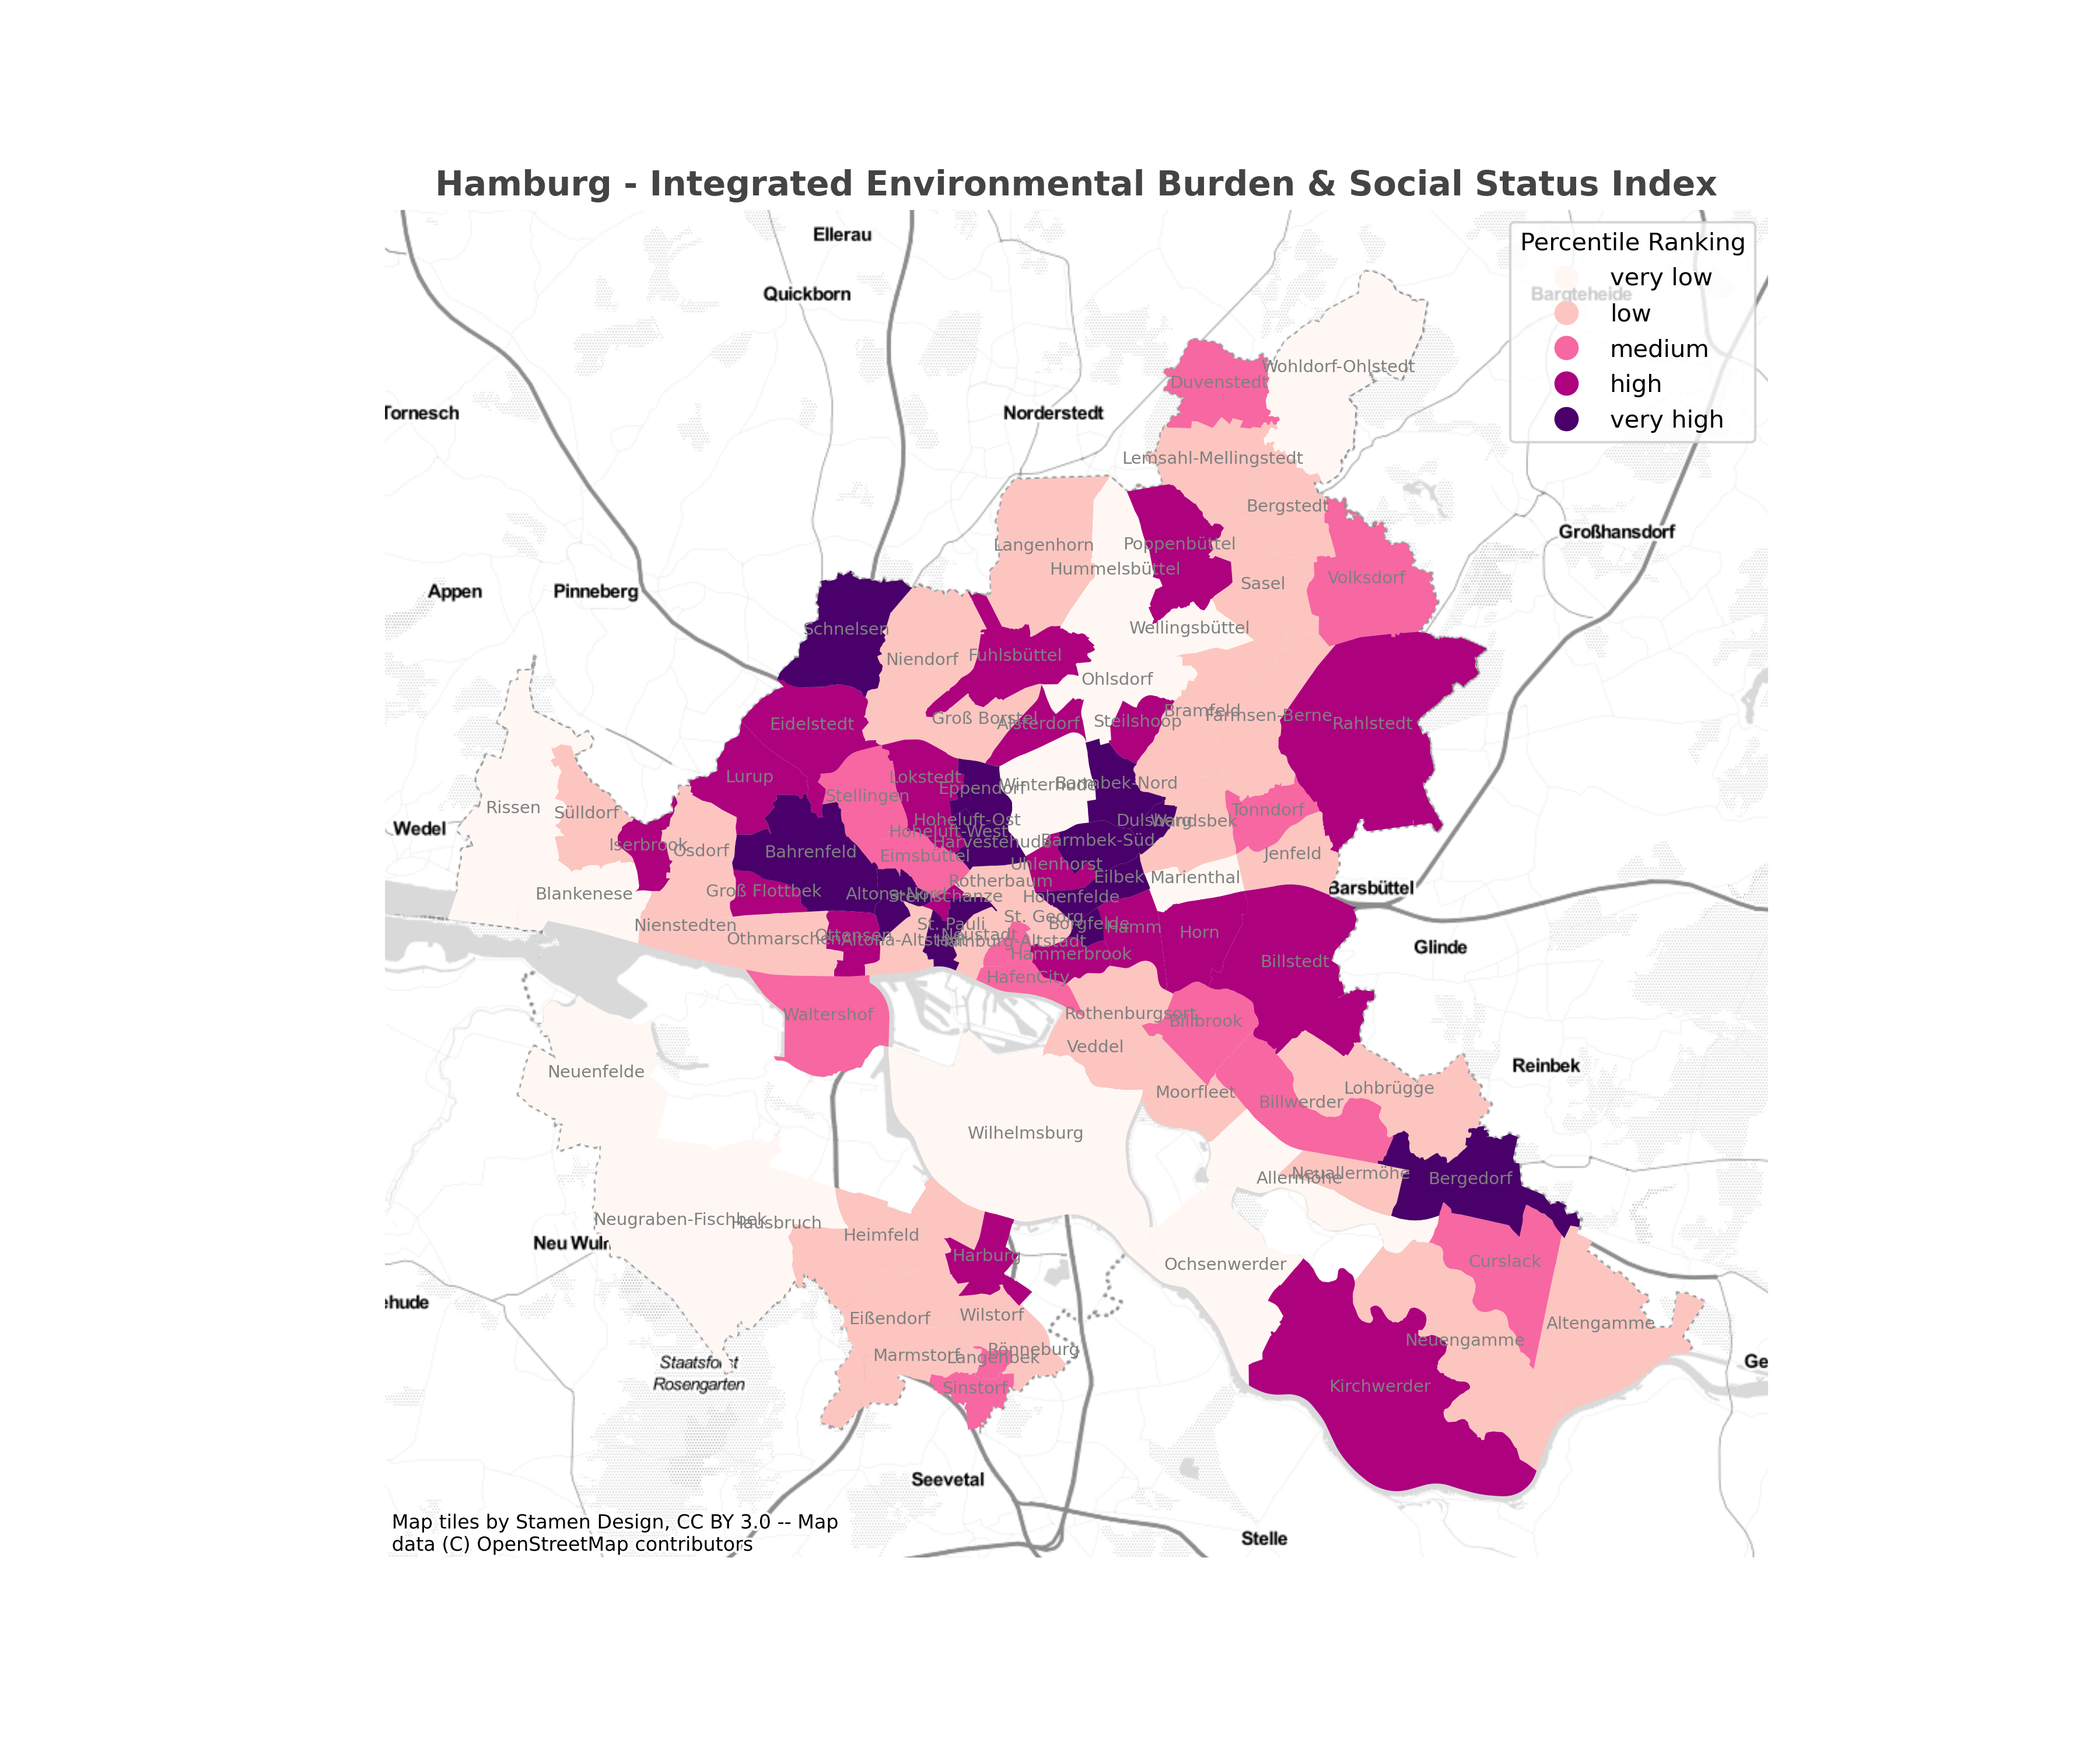

In [27]:
# create the dashboard with sidebar

text = "This dashboard visualizes the results of an analysis related to the topic of environmental justice. The study analyzed and classified four indicators to assess questions in relation to the topic of environmental justice within the city of Hamburg, Germany. The four core indicators are: Social Status, Green Area Supply, Thermal Burden and Noise Pollution. Level of spatial analysis are districts for the City of Hamburg."
text3= "https://github.com/CharlotteGIS/egm722_project/tree/main"

dashboard = pn.template.FastListTemplate(

    title='Dashboard of Environmental and Social Indicators', 
    sidebar=[
        pn.pane.Markdown("# Spatial Analysis of Environmental & Social Indicators"), 
        pn.pane.JPG('data/OIP.jpg', height=80),
        text,
        pn.pane.Markdown("##### Click on the Buttons on top of the Page to initialize interactive maps"),
        pn.pane.PNG('data/map_integrated_indicator.png', height=200),
        pn.pane.Markdown("##### Head over to the GitHub Repository to access the python code and for more explanation on the methdology and data"), 
        text3,
    ],
    main=[
        pn.Row(
            pn.Column(
               #pn.layout.HSpacer(100),  # Add spacer to align content to the center
                indicators_radio,
                map_viewer.view,
                pn.layout.HSpacer(),  # Add spacer to align content to the center
                sizing_mode="stretch_width"
            )),
    
                    
        pn.Row(
            pn.Column(
            plot_scatter_layout,
            sizing_mode="stretch_width"),
            pn.Column(
            bar_plot,
            sizing_mode="stretch_width"),
            
            
        ),
        pn.Row(
            pn.Column(
                table_layout,
                sizing_mode="stretch_width"
            )
        )
    ],
    accent_base_color="#063970",
    header_background="#2596be",
)

dashboard.servable()
